In [1]:
import sys
import os

import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup

from itertools import cycle

import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sys.version

'3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]'

# Getting COVID-19 Case Data

In [2]:
URL_DATA = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df_raw = pd.read_csv(URL_DATA).rename(columns={'Country/Region':'Country', 'Province/State':'State'})

# Fixing some country names
d_names = {'Korea, South': 'South Korea', 'Taiwan*': 'Taiwan', 'US': 'United States'}
df_raw['Country'] = df_raw['Country'].map(lambda x: d_names.get(x, x))

df_raw.head()

,State,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,110,110,120,170,174,237,273,281,299,349
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,186,197,212,223,243,259,277,304,333,361
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,409,454,511,584,716,847,986,1171,1251,1320
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,267,308,334,370,376,390,428,439,466,501
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,4,5,7,7,7,8,8,8,10,14


# Getting Population Data

In [3]:
URL_POP = 'https://www.worldometers.info/world-population/population-by-country/'
response = requests.get(URL_POP).text
soup = BeautifulSoup(response, 'lxml')

table = soup.find_all('table', id=id)[0]
df_pop = pd.read_html(str(table))[0]

df_pop = df_pop.rename(columns={'Country (or dependency)': 'Country', 'Population (2020)': 'Population'})[['Country', 'Population']]

df_pop.head()

,Country,Population
0,China,1439323776
1,India,1380004385
2,United States,331002651
3,Indonesia,273523615
4,Pakistan,220892340


# Cases and Cases per Capita

In [4]:
cols_date = list(set(df_raw.columns) - set(['Country', 'State', 'Lat', 'Long']))

df_c = df_raw[['Country'] + cols_date].groupby('Country').sum().T

df_p = df_raw[['Country'] + cols_date].groupby('Country').sum()
df_p = df_p.merge(df_pop, 'left', on='Country', validate='one_to_one')
df_p[cols_date] = df_p[cols_date].divide(df_p['Population'], 0)
df_p = df_p.drop(columns=['Population']).set_index('Country').T

def setup_index(df):
    df.index.rename('Date', inplace=True)
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)
    
setup_index(df_c)
setup_index(df_p)

print('Latest date: %s' % df_c.index[-1].strftime('%x'))

display(df_c.shape)
display(df_p.shape)

Latest date: 04/05/20


(75, 183)

(75, 183)

In [5]:
l_countries = df_c.columns[df_c.iloc[-1].values.argsort()][::-1].tolist()[:20]

ii = np.arange(0, 20, 2)
ii = np.hstack([ii, ii + 1])
d_color = dict(zip(l_countries, plt.cm.get_cmap('tab20')(ii)))

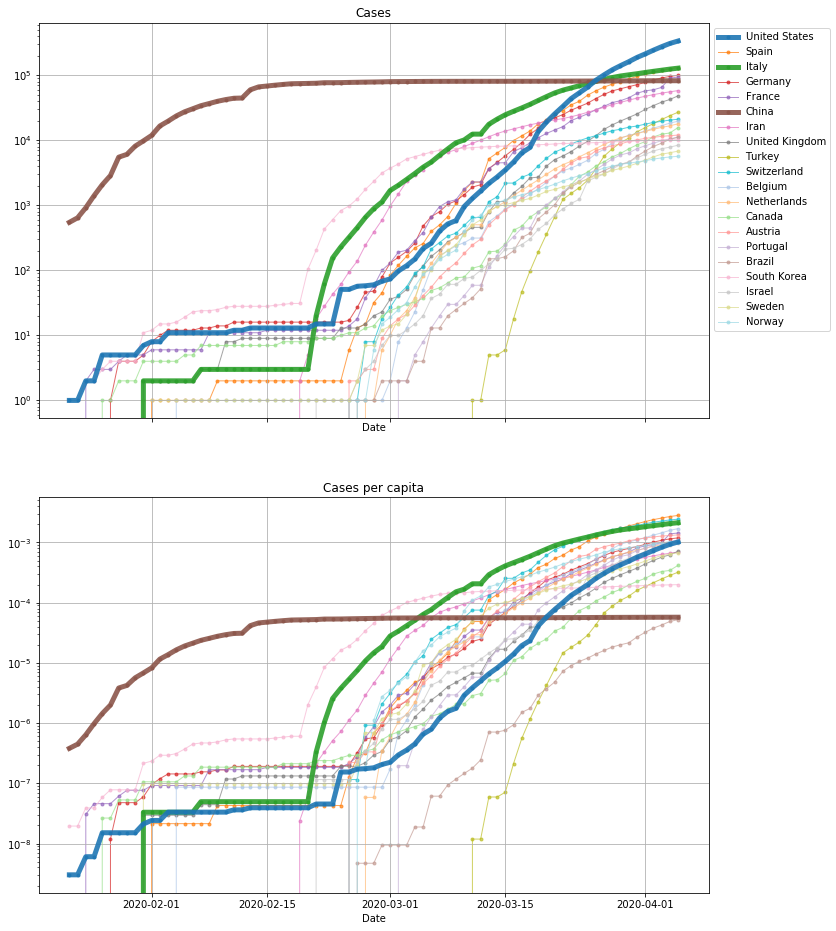

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(12, 16), sharex=True)

def plot_options(country):
    d_z = {'United States':101, 'Italy':100, 'China':100}
    if country in d_z.keys():
        return dict(lw=5, zorder=d_z[country], alpha=0.9)
    return dict(lw=1, zorder=1, alpha=0.7)

def plot_columns(ax, df, cols, d_color):
    for col in cols:
        ax.plot(df[col], color=d_color[col], marker='.', label=col, **plot_options(col))

def fix_up_ax(ax, title, xlabel, legend=True):
    ax.set_yscale('log')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.grid()
    if legend:
        ax.legend(loc=2, bbox_to_anchor=(1, 1))

plot_columns(axs[0], df_c, l_countries, d_color)
fix_up_ax(axs[0], 'Cases', 'Date')

plot_columns(axs[1], df_p, l_countries, d_color)
fix_up_ax(axs[1], 'Cases per capita', 'Date', False)

# Normalizing by days from "100" and "1 in 1M cases"

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


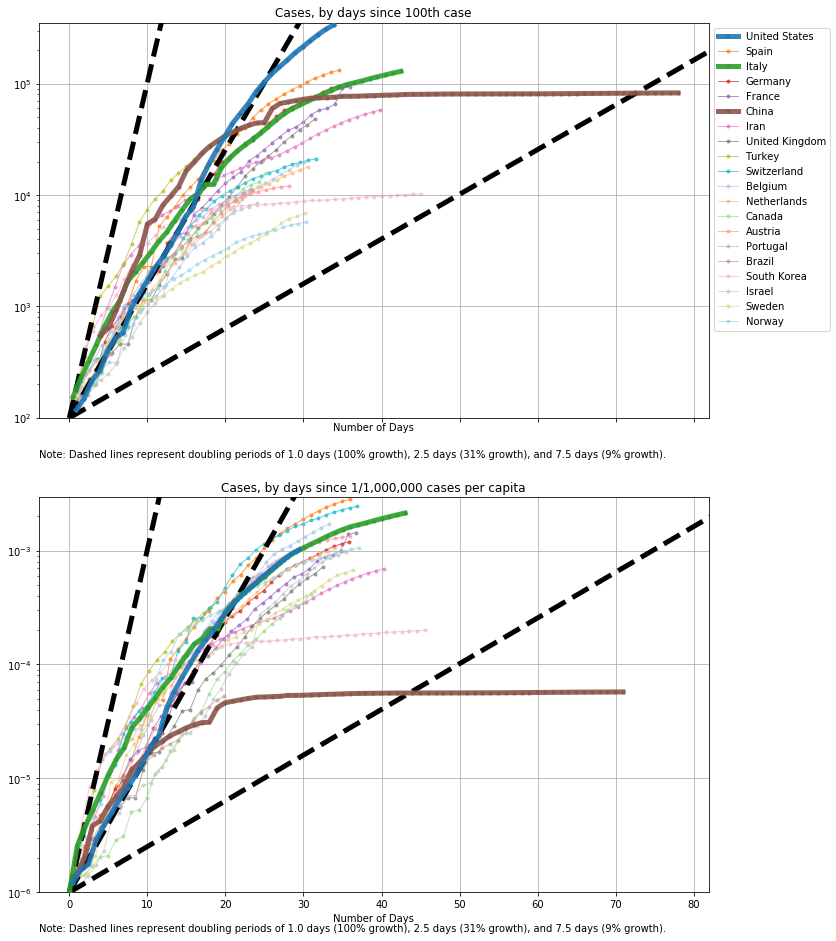

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(12, 16), sharex=True)

ref_cases = [100, 1/1000000]

for ax, df, reference_case in zip(axs, [df_c, df_p], ref_cases):
    
    for country in l_countries:
    
        ds = df[country]
        days = (ds.index - pd.Timestamp('2019-12-31')).days.values # 2020 day number
        day_n = np.interp(np.log10(reference_case), np.log10(ds), days)
        day_n = 18 if country == 'China' and reference_case == 100 else day_n # Best estimate for China
        
        if np.isnan(day_n):
            #print(reference_case, country)
            continue
        
        days_adj = days - day_n
        f_days = days_adj >= 0
        
        ax.plot(days_adj[f_days], ds[f_days], color=d_color[country], marker='.', label=country, **plot_options(country))
    
    # storing current axis limits
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()

    # reference lines
    x = np.linspace(0, 100, 101)
    a_ddub = np.array([1, 2.5, 7.5])
    a_rate = 2 ** (1 / a_ddub)
    for rate in a_rate:
        ax.plot(x, reference_case * rate ** x, ls='--', c='k', lw=5)
    
    # reverting axis limits
    ax.set_ylim(reference_case, ymax)
    ax.set_xlim(xmin, xmax)

    # footnote
    l_str_ddub = ['%.1f days (%d%% growth)' % (ddub, 100 * (rate - 1)) for ddub, rate in zip(a_ddub, a_rate)]
    str_ddub = ', and '.join([', '.join(l_str_ddub[:-1]), l_str_ddub[-1]] if len(l_str_ddub) > 2 else l_str_ddub)
    str_note = 'Note: Dashed lines represent doubling periods of %s.' % str_ddub
    ax.text(0, -0.1, str_note, transform=ax.transAxes)

fix_up_ax(axs[0], 'Cases, by days since %dth case' % ref_cases[0], 'Number of Days')
fix_up_ax(axs[1], 'Cases, by days since 1/%s cases per capita' % '{:,}'.format(int(1 / ref_cases[1])), 'Number of Days', False)